In [1]:
# imports & matplotlib options
%matplotlib notebook

import pyocr.builders
import pyocr
import pandas as pd
import numpy as np
import ipywidgets as widgets
import cv2
import collections
import random
from shutil import copy
from pathlib import Path
from dateutil.parser import parse
from datetime import datetime
from collections import OrderedDict
from autocorrect import spell
from fuzzywuzzy import fuzz, process
from ipywidgets import interact, IntProgress, Label, VBox
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import img_qc.img_qc as img_qc
from PIL import Image

tools = pyocr.get_available_tools()
tool = tools[0]

# plt.rc('figure', figsize=(25.0, 12.0))
display(HTML("<style>.container {width:85% !important;}</style>"))


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-29 03:47:13 PM


In [2]:
# pre-built lists to iterate over
months = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]

roi_box_list = ['text', 'left', 'top', 'width', 'height']

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-29 03:47:13 PM


In [3]:
# test dictionary use
common_mistakes_dict = {'j': 't', 'd': 'j', 't': 'l', '£': 'a'}
for key in common_mistakes_dict:
    print(key)
    print('\t' + common_mistakes_dict[key])

j
	t
d
	j
t
	l
£
	a


In [4]:
# create a dictionary of possible month corrections
months_dict = {}
for month in months:
    correction_list = []
    for i in range(3):
        correction = month[i:]
        if len(correction) > 2:
            correction_list.append(month[i:])
    for i in range(1, 3):
        i = len(month) - i
        correction = month[:i]
        if len(correction) > 2:
            correction_list.append(month[:i])
    # print(correction_list)
    errors_dict = {'j': 't', 'd': 'j', 't': 'l', 'a': '£', 'f': '£', 'a': '&',}
    for error in errors_dict:
        for correction in correction_list:
            if error in correction:
                # print(error, errors_dict[error])
                replaced = correction.replace(error, errors_dict[error])
                # print(replaced)
                correction_list.append(replaced)
        
    months_dict[month] = correction_list
# the first 2 letters can be missing
months_dict

{'january': ['january',
  'anuary',
  'nuary',
  'januar',
  'janua',
  'tanuary',
  'tanuar',
  'tanua',
  'lanuary',
  'lanuar',
  'lanua',
  'j&nu&ry',
  '&nu&ry',
  'nu&ry',
  'j&nu&r',
  'j&nu&',
  't&nu&ry',
  't&nu&r',
  't&nu&',
  'l&nu&ry',
  'l&nu&r',
  'l&nu&'],
 'february': ['february',
  'ebruary',
  'bruary',
  'februar',
  'februa',
  'febru&ry',
  'ebru&ry',
  'bru&ry',
  'febru&r',
  'febru&',
  '£ebruary',
  '£ebruar',
  '£ebrua',
  '£ebru&ry',
  '£ebru&r',
  '£ebru&'],
 'march': ['march',
  'arch',
  'rch',
  'marc',
  'mar',
  'm&rch',
  '&rch',
  'm&rc',
  'm&r'],
 'april': ['april', 'pril', 'ril', 'apri', 'apr', '&pril', '&pri', '&pr'],
 'may': ['may', 'm&y'],
 'june': ['june', 'une', 'jun', 'tune', 'tun', 'lune', 'lun'],
 'july': ['july', 'uly', 'jul', 'tuly', 'tul', 'luly', 'lul'],
 'august': ['august',
  'ugust',
  'gust',
  'augus',
  'augu',
  'augusl',
  'ugusl',
  'gusl',
  '&ugust',
  '&ugus',
  '&ugu',
  '&ugusl'],
 'september': ['september',
  'eptember'

In [5]:
# create page 1 paths list
data_dir_path = Path('/Volumes/jmoor167/data/agrtfn')
page_1_paths_list = sorted(data_dir_path.glob('*.tif'))

# delete macOS '.' index files
regenerate_paths_list = False
for path in page_1_paths_list:
    if path.name.startswith('.'):
        path.unlink()
        regenerate_paths_list = True

if regenerate_paths_list:
    page_1_paths_list = sorted(data_dir_path.glob('*.tif'))

print(f'{len(page_1_paths_list)} images in page 1 paths list')


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')

3451 images in page 1 paths list

*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-29 03:47:13 PM


In [6]:
# utility functions
def crop_image_for_processing(image, percentage=0.4, top_and_sides_padding=10):

    # get technical metadata
    height, width = image.shape[:2]

    # set (x, y) pairs
    x1, y1, x2, y2 = 0, 0, width, int(height * percentage)

    # add/subtract padding from the top/left/right
    x1 += top_and_sides_padding
    y1 += top_and_sides_padding
    x2 -= top_and_sides_padding
    # add image area to the bottom that was cropped from the top
    y2 += top_and_sides_padding

    # crop image
    image = image[y1:y2, x1:x2]

    return image


def get_np_crop_points(crop_box):
    x_points = []
    y_points = []
    # print(f'crop box: {crop_box}')

    # append all x/y points to their respective lists
    for i in range(len(crop_box)):
        if crop_box[i][0][0]:
            x = (crop_box[i][0][0])
            if x < 0:
                x = -x
            x_points.append(x)
        if crop_box[i][0][1]:
            y = crop_box[i][0][1]
            if y < 0:
                y = -y
            y_points.append(y)
    # print('x/y points')
    # print(x_points, y_points)

    # find extremes in crop box
    x1 = min(x_points)
    x2 = max(x_points)
    y1 = min(y_points)
    y2 = max(y_points)
    # print(f'x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}')

    return x1, y1, x2, y2


def if_rgb_convert_to_gray(np_image):
    if len(np_image.shape) > 2:
        np_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2GRAY)

    return np_image


def if_bgr_convert_to_gray(np_image):
    if len(np_image.shape) > 2:
        np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2GRAY)

    return np_image


def resize(image, width=None, height=None, ratio=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        ratio = height / float(h)
        dim = (int(w * ratio), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        ratio = width / float(w)
        dim = (width, int(h * ratio))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized, ratio


def resize_ratio(image, ratio, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    dim = (int(w * ratio), int(h * ratio))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized


def quick_imshow(bgr_image):
    if len(bgr_image.shape) > 2:
        bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = 'gray'
    plt.imshow(bgr_image, cmap=cmap), plt.show()
    
    return


print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-29 03:47:18 PM


In [7]:
class TnFarmNews:

    def __init__(self, image_path, config=False):

        self.image_path = Path(image_path)

        # set config dictionary
        if config:
            self.config = config
        else:
            self.config = {'crop_percentage': 0.4,
                           'distance_ratio': 0.6,
                           'minimum_matches': 5,
                           'top_and_bottom_padding': 10,
                           'resize_width': 1500}

        # set variables
        self.MOST_MATCHES = self.config['minimum_matches']
        self.BEST_SSIM_WITH_TITLE = -1  # on a scale of -1->1, 1 is a perfect match
        self.BEST_TITLE_CROP = False
        self.BEST_TITLE = False
        self.RESIZE_RATIO = False

    def preprocess_image(self, crop_percentage=None, top_and_bottom_padding=None):

        if not crop_percentage:
            crop_percentage = self.config['crop_percentage']
        if not top_and_bottom_padding:
            top_and_bottom_padding = self.config['top_and_bottom_padding']

        # load image
        self.image = cv2.imread(str(self.image_path))

        # get technical metadata
        self.height, self.width = self.image.shape[:2]
        if len(self.image.shape) > 2:
            self.colorspace = 'gray'
        else:
            self.colorspace = 'rgb'

        # crop image and get shape
        self.image_cropped = crop_image_for_processing(
            self.image, crop_percentage, top_and_bottom_padding)
        self.height_cropped, self.width_cropped = self.image_cropped.shape[:2]

        return self.image_cropped

    def guess_title(self, crop_dictionary, image=None, debug=None):

        print(f'Guessing title of {self.image_path.name} . . .')

        # resize cropped image and get features
        # if self.RESIZE_RATIO:
        #     image = resize_ratio(self.image_cropped, self.RESIZE_RATIO)
        # else:
        #     image, self.RESIZE_RATIO = resize(
        #         self.image_cropped, width=self.config['resize_width'])

        if not image:
            image = self.preprocess_image()

        self.keypoints, self.descriptors = get_keypoints_and_descriptors(image)

        best_per_title_dict = OrderedDict()

        for title, data in crop_dictionary.items():

            if title not in best_per_title_dict:  # instantiate an OrderedDict()
                # number_of_matches, crop_box
                best_per_title_dict[title] = OrderedDict()
                best_per_title_dict[title] = [0, False, False, False]
                if debug:
                    print(title)

            for sub_title, sub_data in crop_dictionary[title].items():

                crop_image, crop_keypoints, crop_descriptors = sub_data
                # quick_imshow(crop_image)

                number_of_matches, matches = get_descriptor_matches(
                    crop_descriptors, self.descriptors, self.config['distance_ratio'])
                if debug:
                    print(sub_title)
                    print(
                        f'# of matches/minMatches: {number_of_matches}/{(self.MOST_MATCHES * 0.5)}')

                # then it might be the best match
                if number_of_matches >= (self.MOST_MATCHES * 0.5):

                    found_image, crop_box = get_matching_crop_and_box(
                        matches, crop_keypoints, self.keypoints, crop_image, image)

                    try:
                        if not crop_box:  # then we didn't get a valid crop_box
                            if debug:
                                print(f'\t\tFalse positive: invalid crop_box')
                            continue
                    except ValueError:  # valid numpy array throws a ValueError when testing existence

                        if debug:
                            print(f'crop box: {crop_box}')
                        x1, y1, x2, y2 = get_np_crop_points(crop_box)

                        # x1 = int(x1 / self.RESIZE_RATIO)
                        # y1 = int(y1 / self.RESIZE_RATIO)
                        # x2 = int(x2 / self.RESIZE_RATIO)
                        # y2 = int(y2 / self.RESIZE_RATIO)

                        # if width/height of title isn't over min_title_width/height pixels
                        # it's not the title
                        min_title_width = 800
                        min_title_height = 40
                        title_width = x2 - x1
                        title_height = y2 - y1

                        if (x2 - x1 < min_title_width):
                            if debug:
                                print(f'\t\t\tFalse positive: width < minimum')
                                print(
                                    f'\t\t\t\t{x2} - {x1} = {title_width} < {min_title_width}')
                            continue
                        elif (y2 - y1 < min_title_height):
                            if debug:
                                print(f'\t\t\tFalse positive: height < minimum')
                                print(
                                    f'\t\t\t\t{y2} - {y2} = {title_height} < {min_title_height}')
                            continue

                        if debug:
                            print(x1, y1, x2, y2)
                            crop = self.image_cropped[int(
                                y1):int(y2), int(x1):int(x2)]
                            print(f'cropped image')
                            quick_imshow(crop)

                        # convert to grayscale for ssim
                        found_gray = if_bgr_convert_to_gray(found_image)
                        crop_gray = if_bgr_convert_to_gray(crop_image)

                        # get the structural similiarity index of the match with the image for a 2nd heuristic
                        try:
                            if debug:
                                print('found_gray')
                                quick_imshow(found_gray)
                                print(f'crop_gray')
                                quick_imshow(crop_gray)
                            ssim_value = ssim(found_gray, crop_gray)
                            if ssim_value > self.BEST_SSIM_WITH_TITLE:
                                print(f'new best ssim: {title, ssim_value}')
                                self.BEST_SSIM_WITH_TITLE = ssim_value
                                points = [x1, y1, x2, y2]
                                self.BEST_TITLE_CROP = points
                                self.BEST_TITLE = title
                                self.MOST_MATCHES = number_of_matches

                        except ValueError:  # image shape doesn't match, so most likely incorrect title
                            print('wrong dimensions')
                            continue
        return

    def binarize(self, image=None, debug=None):

        if type(image) is not np.ndarray:
            image = self.preprocess_image()

        # convert to gray and blur
        image = if_bgr_convert_to_gray(image)
        image = cv2.GaussianBlur(image, (3, 3), 1)

        # binarize
        self.binarized = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 175, 21)
        
        return self.binarized

    def ocr(self, image=None, debug=None):
        
        if type(image) is not np.ndarray:
            image = self.binarize()
        
        # show image we're OCRing
        # quick_imshow(image)
        
        # create line and word boxes
        line_and_word_boxes = tool.image_to_string(
            Image.fromarray(image),
            lang='eng',
            builder=pyocr.builders.LineBoxBuilder(),
        )
        # create text
        text = tool.image_to_string(
            Image.fromarray(image),
            lang='eng',
            builder=pyocr.builders.TextBuilder(),
        )

        return line_and_word_boxes, text
    
    def ocr_thrice(self, image=None, debug=None):
        
        if type(image) is not np.ndarray:
            image = self.binarize()
            
        height, width = image.shape[:2]
        
        # ocr everything
        self.ocr_all = self.ocr(image)
        self.ocr_all_lines = self.ocr_all[0]
        self.ocr_all_text = self.ocr_all[1]
        
        # crop and ocr right half
        image = image[0:height, int(width/2):width]
        self.ocr_right = self.ocr(image)
        self.ocr_right_lines = self.ocr_right[0]
        self.ocr_right_text = self.ocr_right[1]
        
        # crop and ocr left half
        image = image[0:height, 0:int(width/2)]
        self.ocr_left = self.ocr(image)
        self.ocr_left_lines = self.ocr_left[0]
        self.ocr_left_text = self.ocr_left[1]
        
        # return ocr_all
        return self.ocr_all

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-29 03:47:20 PM


In [1]:
# Non-maximum suppression
# https://gist.github.com/CMCDragonkai/1be3402e261d3c239a307a3346360506

In [2]:
# ocr functions
def search(values, searchFor):
    for k in values:
        for v in values[k]:
            if searchFor in v:
                return k
    return None


class OcrResults:
    def __init__(self, line_and_word_boxes):
        self.filter_chars = 'abcdefghijklmnopqrstuvwxyz1234567890£& '
        self.line_and_word_boxes = line_and_word_boxes

    def get_month(self, debug=False):
        
        self.months = OrderedDict()
        number_of_months = 0

        # iterate over lines in the OCR result
        for line in self.line_and_word_boxes:
            # filter out everything that's not a a-z,0-9, and a 'space'
            line_condensed = [
                x for x in line.content if x.lower() in self.filter_chars]

            # filtering produces a list of chars, so join it into a line of text
            text = ''.join(line_condensed)

            # split the joined text into words at each space
            for word in text.split(' '):

                # only process word results over 2 chars in length
                if len(word) > 2:

                    # try to match the word as lower-case with the months dictionary
                    month = search(months_dict, word.lower())

                    if month is None:  # try autocorrecting the word and searching again
                        fixed_word = spell(word)
                        if debug:
                            print(f'fixed_word: {fixed_word}')
                        month = search(months_dict, fixed_word.lower())

                    if month is None:  # continue on to the next word
                        continue
                        
                    # get the word 
                    for index, box in enumerate(line.word_boxes):
                        if box.content == word:
                            found_month = month
                            # print(box.content)
                            # print(box.position)
                            if debug:
                                print(f'index: {index}')
                                if index > 0:
                                    word_before = line.word_boxes[index-1].content
                                    print(f'word before: {word_before}')
                                word_found = line.word_boxes[index].content
                                print(f'word: {word_found}')
                                word_after = line.word_boxes[index+1].content
                                print(f'word after: {word_after}')
                            (x1, y1), (x2, y2) = box.position[:2]
                            crop_box = [x1, y1, x2, y2]
                            number_of_months += 1
                            yield found_month, word, crop_box
        # otherwise
        if number_of_months > 0:
            return
        else:
            yield None

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')

NameError: name 'datetime' is not defined

In [ ]:
string = 'string'
string = ' '.join(string)

In [ ]:
# string = 'string'
print(string)
for index, char in enumerate(string.split(' ')):
    print(f'index: {index}')
    print(f'\tchar: "{char}"')
    print(f'\tslice list by index +1:')
    print(f'\t\t\t\tstring[{index+1:}:]: {" ".join(string.split(" ")[index+1:])}')

In [38]:
csv_path = Path('/Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv')
if csv_path.is_file():
    processed_df = pd.read_csv(csv_path)
else:
    processed_df = pd.DataFrame()
processed_df

,date_crop_box,date_guess,date_guess_id,image_name
0,"(1847, 139, 2401, 239)",13-Jul-25,1,0012_004266_000001_0001.tif
1,"(2092, 436, 2750, 541)",NaN,1,0012_004266_000002_0001.tif
2,"(2629, 355, 2980, 485)","July 4,",1,0012_004266_000003_0001.tif
3,"(2172, 361, 2754, 477)",11-Jul-21,1,0012_004266_000004_0001.tif
4,"(2339, 371, 2896, 487)",18-Jul-22,1,0012_004266_000005_0001.tif
5,"(2339, 375, 2896, 483)",16-Jul-22,4,0012_004266_000005_0001.tif
6,"(419, 1401, 971, 1494)",June 29 to July,2,0012_004266_000005_0001.tif
7,"(782, 1400, 1349, 1504)",July 8 were red-,3,0012_004266_000005_0001.tif
8,"(2243, 349, 2797, 455)",25-Jul-21,1,0012_004266_000006_0001.tif
9,NaN,NaN,1,0012_004266_000007_0001.tif


In [39]:
class TnFarmNews:

    def __init__(self, image_path, config=False):

        # instantiate image_path and load image
        self.image_path = Path(image_path)
        self.image = cv2.imread(str(self.image_path))

        # set config dictionary
        if config:
            self.config = config
        else:
            self.config = {'crop_percentage': 0.4,
                           'distance_ratio': 0.6,
                           'minimum_matches': 5,
                           'top_and_bottom_padding': 10,
                           'resize_width': 1000}

        # set variables
        self.MOST_MATCHES = self.config['minimum_matches']
        self.BEST_SSIM_WITH_TITLE = -1  # on a scale of -1->1, 1 is a perfect match
        self.BEST_TITLE_CROP = False
        self.BEST_TITLE = False
        self.RESIZE_RATIO = False

    def preprocess_image(self, crop_percentage=None, top_and_bottom_padding=None):

        if not crop_percentage:
            crop_percentage = self.config['crop_percentage']
        if not top_and_bottom_padding:
            top_and_bottom_padding = self.config['top_and_bottom_padding']

        # get technical metadata
        self.height, self.width = self.image.shape[:2]
        if len(self.image.shape) > 2:
            self.colorspace = 'gray'
        else:
            self.colorspace = 'rgb'

        # crop image and get shape
        self.image_cropped = crop_image_for_processing(
            self.image, crop_percentage, top_and_bottom_padding)
        self.height_cropped, self.width_cropped = self.image_cropped.shape[:2]

        return self.image_cropped

    def guess_title(self, crop_dictionary, image=None, debug=None):

        print(f'Guessing title of {self.image_path.name} . . .')

        if not image:
            image = self.preprocess_image()

        self.keypoints, self.descriptors = get_keypoints_and_descriptors(image)

        best_per_title_dict = OrderedDict()

        for title, data in crop_dictionary.items():

            if title not in best_per_title_dict:  # instantiate an OrderedDict()
                # number_of_matches, crop_box
                best_per_title_dict[title] = OrderedDict()
                best_per_title_dict[title] = [0, False, False, False]
                if debug:
                    print(title)

            for sub_title, sub_data in crop_dictionary[title].items():

                crop_image, crop_keypoints, crop_descriptors = sub_data
                # quick_imshow(crop_image)

                number_of_matches, matches = get_descriptor_matches(
                    crop_descriptors, self.descriptors, self.config['distance_ratio'])
                if debug:
                    print(sub_title)
                    print(
                        f'# of matches/minMatches: {number_of_matches}/{(self.MOST_MATCHES * 0.5)}')

                # then it might be the best match
                if number_of_matches >= (self.MOST_MATCHES * 0.5):

                    found_image, crop_box = get_matching_crop_and_box(
                        matches, crop_keypoints, self.keypoints, crop_image, image)

                    try:
                        if not crop_box:  # then we didn't get a valid crop_box
                            if debug:
                                print(f'\t\tFalse positive: invalid crop_box')
                            continue
                    except ValueError:  # valid numpy array throws a ValueError when testing existence

                        if debug:
                            print(f'crop box: {crop_box}')
                        x1, y1, x2, y2 = get_np_crop_points(crop_box)

                        # x1 = int(x1 / self.RESIZE_RATIO)
                        # y1 = int(y1 / self.RESIZE_RATIO)
                        # x2 = int(x2 / self.RESIZE_RATIO)
                        # y2 = int(y2 / self.RESIZE_RATIO)

                        # if width/height of title isn't over min_title_width/height pixels
                        # it's not the title
                        min_title_width = 800
                        min_title_height = 40
                        title_width = x2 - x1
                        title_height = y2 - y1

                        if (x2 - x1 < min_title_width):
                            if debug:
                                print(f'\t\t\tFalse positive: width < minimum')
                                print(
                                    f'\t\t\t\t{x2} - {x1} = {title_width} < {min_title_width}')
                            continue
                        elif (y2 - y1 < min_title_height):
                            if debug:
                                print(f'\t\t\tFalse positive: height < minimum')
                                print(
                                    f'\t\t\t\t{y2} - {y2} = {title_height} < {min_title_height}')
                            continue

                        if debug:
                            print(x1, y1, x2, y2)
                            crop = self.image_cropped[int(
                                y1):int(y2), int(x1):int(x2)]
                            print(f'cropped image')
                            quick_imshow(crop)

                        # convert to grayscale for ssim
                        found_gray = if_bgr_convert_to_gray(found_image)
                        crop_gray = if_bgr_convert_to_gray(crop_image)

                        # get the structural similiarity index of the match with the image for a 2nd heuristic
                        try:
                            if debug:
                                print('found_gray')
                                quick_imshow(found_gray)
                                print(f'crop_gray')
                                quick_imshow(crop_gray)
                            ssim_value = ssim(found_gray, crop_gray)
                            if ssim_value > self.BEST_SSIM_WITH_TITLE:
                                print(f'new best ssim: {title, ssim_value}')
                                self.BEST_SSIM_WITH_TITLE = ssim_value
                                points = [x1, y1, x2, y2]
                                self.BEST_TITLE_CROP = points
                                self.BEST_TITLE = title
                                self.MOST_MATCHES = number_of_matches

                        except ValueError:  # image shape doesn't match, so most likely incorrect title
                            print('wrong dimensions')
                            continue
        return

    def binarize(self, image=None, debug=None):

        if type(image) is not np.ndarray:
            image = self.preprocess_image()

        # convert to gray and blur
        image = if_bgr_convert_to_gray(image)
        image = cv2.GaussianBlur(image, (3, 3), 1)

        # binarize
        self.binarized = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 175, 21)
        
        return self.binarized

    def ocr(self, image=None, debug=None):
        
        if type(image) is not np.ndarray:
            image = self.binarize()
        
        # show image we're OCRing
        # quick_imshow(image)
        
        # create line and word boxes
        line_and_word_boxes = tool.image_to_string(
            Image.fromarray(image),
            lang='eng',
            builder=pyocr.builders.LineBoxBuilder(),
        )
        # create text
        text = tool.image_to_string(
            Image.fromarray(image),
            lang='eng',
            builder=pyocr.builders.TextBuilder(),
        )

        return line_and_word_boxes, text
    
    def box_crop(self, crop_box, image=None):
        
        print(f'crop_box: {crop_box}')
        # set crop_box
        x1, y1, x2, y2 = crop_box

        try:  # cropping the image
            self.image_box_crop = image[y1:y2, x1:x2]
        except TypeError:  # because it's *probably* a NoneType
            # load image from class
            self.image_box_crop = self.image[y1:y2, x1:x2]
        
        return self.image_box_crop
    
    def draw_box(self, image, crop_box):
    
        x1, y1, x2, y2 = crop_box

        # draw rectangle
        self.drawing = cv2.rectangle(image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 2)

        return self.drawing
    
    def ocr_thrice(self, image=None, debug=None):
        
        if type(image) is not np.ndarray:
            image = self.binarize()
            
        height, width = image.shape[:2]
        
        # ocr everything
        self.ocr_all = self.ocr(image)
        self.ocr_all_lines = self.ocr_all[0]
        self.ocr_all_text = self.ocr_all[1]
        
        # crop and ocr right half
        image = image[0:height, int(width/2):width]
        self.ocr_right = self.ocr(image)
        self.ocr_right_lines = self.ocr_right[0]
        self.ocr_right_text = self.ocr_right[1]
        
        # crop and ocr left half
        image = image[0:height, 0:int(width/2)]
        self.ocr_left = self.ocr(image)
        self.ocr_left_lines = self.ocr_left[0]
        self.ocr_left_text = self.ocr_left[1]
        
        # return ocr_all
        return self.ocr_all
        

print(f'\n{25 * "*_*"}\nLast run on {datetime.now().strftime("%Y-%m-%d %I:%M:%S %p")}')


*_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_**_*
Last run on 2019-08-29 05:53:28 PM


In [40]:
# create paths list from text_file
images_to_process_text_file = Path('/Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date_to_process.txt')
paths_list = []
with open (images_to_process_text_file, 'r') as text_file:
    for line in text_file:
        line = line.strip('\n')
        paths_list.append(line)

In [19]:
paths_list

['0012_004266_000007_0001.tif',
 '0012_004266_000015_0001.tif',
 '0012_004266_000029_0001.tif',
 '0012_004266_000030_0001.tif',
 '0012_004266_000037_0001.tif',
 '0012_004266_000042_0001.tif',
 '0012_004266_000044_0001.tif',
 '0012_004266_000069_0001.tif',
 '0012_004266_000081_0001.tif',
 '0012_004266_000082_0001.tif',
 '0012_004266_000103_0001.tif',
 '0012_004266_000133_0001.tif',
 '0012_004266_000144_0001.tif',
 '0012_004266_000154_0001.tif',
 '0012_004266_000164_0001.tif',
 '0012_004266_000181_0001.tif',
 '0012_004266_000189_0001.tif',
 '0012_004266_000208_0001.tif',
 '0012_004266_000211_0001.tif',
 '0012_004266_000214_0001.tif',
 '0012_004266_000215_0001.tif',
 '0012_004266_000263_0001.tif',
 '0012_004266_000268_0001.tif',
 '0012_004266_000274_0001.tif',
 '0012_004266_000276_0001.tif',
 '0012_004266_000277_0001.tif',
 '0012_004266_000282_0001.tif',
 '0012_004266_000287_0001.tif',
 '0012_004266_000292_0001.tif',
 '0012_004266_000300_0001.tif',
 '0012_004266_000303_0001.tif',
 '0012_0

In [43]:
# batch process text

rows_list = []

images_to_process_before_saving_csv = 20

# paths_list = page_1_paths_list
# paths_list = random.sample(page_1_paths_list, len(page_1_paths_list))
number_of_paths = len(paths_list)

# progress bar
progress_label = Label('Images to process')
progress_bar = IntProgress(min=0, max=number_of_paths)
progress_widget = VBox([progress_label, progress_bar])
display(progress_widget)

# create list of images already in dataframe
images_in_csv_list = processed_df.image_name.unique().tolist()

for index, image_name in enumerate(paths_list, start=1):
    
    # if the image_path is already in the dataframe skip it
    if image_name in images_in_csv_list:
        # if modulo of processed images is 0 or it's the last image save data to the CSV 
        if (index % images_to_process_before_saving_csv) == 0 or index == number_of_paths:
            if len(rows_list) > 0:
                print(f'Saving data from {index} images to {csv_path}')

                # get dataframe from processed rows
                crop_df = pd.DataFrame(rows_list)

                # add dataframes together
                processed_df = pd.concat([processed_df, crop_df])

                # drop duplicates
                processed_df.drop_duplicates(inplace=True)

                # sort on image_path and reset the index
                processed_df = processed_df.sort_values(by='image_name').reset_index(drop=True)
                processed_df.to_csv(csv_path, index=False)

                # reset rows_list
                rows_list = []
        continue
    
    image_path = data_dir_path.joinpath(image_name)
    label = f'Processing {image_path.name} . . . {index+1}/{number_of_paths}'
    progress_label.value = label
    
    
    # process image
    issue = TnFarmNews(image_path)
    # print(issue.image_path.name)
    issue.ocr_thrice()
    image = issue.image_cropped
    # quick_imshow(image)
    height, width = issue.height_cropped, issue.width_cropped

    ocr_results_dict = {'all': issue.ocr_all_lines,
                        'left': issue.ocr_left_lines,
                        'right': issue.ocr_right_lines}

    crop_and_text_dict = OrderedDict()

    for area_ocred in ocr_results_dict:

        # print(f'OCRing image area "{area_ocred}" . . .')

        # instantiate OcrResults class to find month
        ocr_results = OcrResults(ocr_results_dict[area_ocred])

        # loop through results
        for i, result in enumerate(ocr_results.get_month()):
            # print(f'Result: {i + 1}\n{25 * "="}')
            if result is None:
                # print(issue.text)
                # print('\t\t\t\tNo acceptable results\n')
                continue
            else:
                month, word, crop_box = result
                # print(f'\t\t\t\t{month.capitalize(), word}')
                x1, y1, x2, y2 = crop_box
                
                if area_ocred == 'right':
                    cropped_width = int(width/2)
                    # add cropped back to x1 and x2
                    x1 += cropped_width
                    x2 += cropped_width
                # print(f'month crop_box: {crop_box}')
                # quick_imshow(image[y1:y2, x1:x2])

                # get larger crop_box and re-OCR
                x1 -= 25
                x1 = max(x1, 0)
                y1 -= 25
                y1 = max(y1, 0)
                x2 += 400
                x2 = min(x2, width)
                y2 += 25
                y2 = min(y2, height)

                # draw this box on larger image
                # drawing = cv2.rectangle(
                #     image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 8)
                # print('expanded month crop box on image')
                # quick_imshow(drawing)

                # crop to sub_image and ocr
                sub_image = image[y1:y2, x1:x2]
                sub_image = issue.binarize(sub_image)
                line_and_word_boxes, text = issue.ocr(sub_image)
                
                # print(f'Text:\n"{text}"\n\n')
                # print(f'{len(line_and_word_boxes)} lines in sub_image')
                
                # package sub_image's crop_box for dictionary
                date_crop_box = (x1, y1, x2, y2)
                
                # it's possible there's more than 1 line of text 
                # so make each one a possible date
                for line in line_and_word_boxes:
                    # print(line.content)
                    
                    # replace new lines with spaces
                    line = line.content.replace('\n', ' ')
                    # print(line)
                    # strip periods, single/double-quotes, and spaces at the beginning and end of the line
                    line = line.strip('.').strip(' ').strip("'").strip('"')
                    # print(line)
                    
                    # many of the lines are obviously not dates
                    # so only add lines/crop_boxes if
                    # the line contains any numbers
                    for char in line:
                        if char.isdigit():
                            crop_and_text_dict[line] = date_crop_box
                            break
                            

    # process OCR results
    
    count_for_csv = 1
    if len(crop_and_text_dict) < 1:
        # get input row in dictionary format
        # key = column_name
        results_dictionary = {'date_guess_id': count_for_csv,
                              'image_name': image_path.name,
                              'date_guess': None,
                              'date_crop_box': None,
                              # 'year_guess': issue.MOST_MATCHES,
                              }

        for key in results_dictionary:
            if results_dictionary[key]:
                continue
            else:
                results_dictionary.update({key: None})

        rows_list.append(results_dictionary)
    
    for date in crop_and_text_dict:
        
        parsed_date = None
        month = None
        date_guess = None
        
        if len(date) < 5:
            continue
        try:
            # print(f'Processing: "{date}"')
            parsed_date = parse(date)

        except ValueError:  # couldn't parse the date
            # split on spaces and look for each word in the months dictionary
            words = date.split(' ')
            for i, word in enumerate(words):
                
                word = str(word)  # cast word as a string in case of weirdness
                
                # only process word results over 2 chars in length
                if len(word) > 2:
                    
                    best_word = word

                    # try to match the word as lower-case with the months dictionary
                    month = search(months_dict, word.lower())  # returns None on failed search

                    if month is None:  # try autocorrecting the word and searching again
                        fixed_word = spell(word)
                        # print(f'fixed_word: {fixed_word}')
                        month = search(months_dict, fixed_word.lower())
                        best_word = fixed_word
                    
                    # try adding the previous word to every word after the first and re-searching
                    if i > 0 and month is None:
                        word_plus_word_before = words[i-1] + word
                        month = search(months_dict, word_plus_word_before.lower())
                        best_word = word_plus_word_before
                    
                    # try adding the next word to every word but the last
                    if i+1 < (len(words)) and month is None:
                        word_plus_word_after = word + words[i+1]
                        month = search(months_dict, word_plus_word_after.lower())
                        best_word = word_plus_word_after
                        

                    if month is None:  # continue to the next word
                        continue
                    else:
                        # print(f'word guess for {month} from best word: {best_word}')
                        # set day_year to index + 1 to the end of words list
                        day_year = ' '.join(words[i+1:])  # join the words list and add the space back
                        
                        corrected_date = f'{month} {day_year}'
                        # print(f'after: {corrected_date}')
                        try:
                            parsed_date = parse(corrected_date)
                            # print(f'parsed date: {parsed_date}')
                        except ValueError:
                            try:
                                parsed_date = parse(corrected_date, fuzzy=True)
                                # print(f'fuzzy parsed date: {parsed_date}')
                            except ValueError:
                                # parsed_date = "Date couldn't be parsed"
                                continue
        
        if parsed_date is None:
            # if we found a month go ahead and post the text value
            # of the found date as it may be correct
            # print(f'month in parsed_data is None: {month}')
            if month:
                date_guess = str(date)
            else:
                date_guess = None

        # if date after 2000 just pass the text
        elif int(parsed_date.strftime("%Y")) > 1999:
            date_guess = str(date)
        #     if month:
        #         date_guess = str(date)
        #     else:
        #         date_guess = None
        
        else:
            # print(f'Type of parsed_date: {type(parsed_date)}')
            date_guess = parsed_date.strftime("%B %e, %Y")
            month = parsed_date.strftime("%B")
            day = parsed_date.strftime("%d")  # %d keeps leading zero on days
            day_no_leading_zero = parsed_date.strftime("%e")  # %e drops it
            year = parsed_date.strftime("%Y")
            # if first digit of year is 0, change it to 1
            if int(year[0]) == 0:
                # print(f'year <1000: {year}')
                year = '1' + year[1:]
                # print(f'year fixed: {year}')
                # then rebuild date_guess
                date_guess = f'{month} {day_no_leading_zero}, {year}'
            elif int(year[1]) != 9:
                year = '19' + year[2:]
                # then rebuild date_guess
                date_guess = f'{month} {day_no_leading_zero}, {year}'

        crop_box = crop_and_text_dict[date]
        
        x1, y1, x2, y2 = crop_box
        
#         # draw this box on the ocr_all image
#         drawing = cv2.rectangle(image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 8)
#         # draw a black rectangle above this to add text to
#         drawing = cv2.rectangle(drawing, (x1, y1-100), (x2, y1), (0, 0, 0), -1)  # negative thickness to fill rectangle
        
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         print(f'date_guess before fail: {date_guess}')
#         if date_guess is not None:
#             date_writing = date_guess
#         else:
#             date_writing = 'Date Guess Fail'
#         cv2.putText(drawing, date_writing, (x1+25, (y1-25)), font, 2, (255,255,255), 3, cv2.LINE_AA)
              
#         quick_imshow(drawing)
        
        # get input row in dictionary format
        # key = column_name
        results_dictionary = {'date_guess_id': count_for_csv,
                              'image_name': image_path.name,
                              'date_guess': date_guess,
                              'date_crop_box': crop_box,
                              # 'year_guess': issue.MOST_MATCHES,
                              }

        for key in results_dictionary:
            if results_dictionary[key]:
                continue
            else:
                results_dictionary.update({key: None})

        rows_list.append(results_dictionary)
        # increment counter for imageID 
        count_for_csv += 1
        
    progress_bar.value = index
    
    # if modulo of processed images is 0 or it's the last image save data to the CSV 
    if (index % images_to_process_before_saving_csv) == 0 or index == number_of_paths:
        
        print(f'Saving data from {index} images to {csv_path}')
        
        # get dataframe from processed rows
        crop_df = pd.DataFrame(rows_list)
        
        # add dataframes together
        processed_df = pd.concat([processed_df, crop_df])

        # drop duplicates
        processed_df.drop_duplicates(inplace=True)

        # sort on image_path and reset the index
        processed_df = processed_df.sort_values(by='image_name').reset_index(drop=True)
        processed_df.to_csv(csv_path, index=False)
        
        # reset rows_list
        rows_list = []

Saving data from 20 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 40 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 60 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 80 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 100 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 120 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 140 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 160 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 180 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Saving data from 200 images to /Users/jeremy/Documents/GitHub/utk_ProjectCeres/data/agrtfn_date.csv
Savi

In [ ]:
rows_list

In [42]:
# get dataframe from processed rows
crop_df = pd.DataFrame(rows_list)

# add dataframes together
processed_df = pd.concat([processed_df, crop_df], sort=False)

# drop duplicates
processed_df.drop_duplicates(inplace=True)

# sort on image_path and reset the index
processed_df = processed_df.sort_values(by='image_name').reset_index(drop=True)
processed_df.to_csv(csv_path, index=False)

# reset rows_list
rows_list = []

<IPython.core.display.Javascript object>


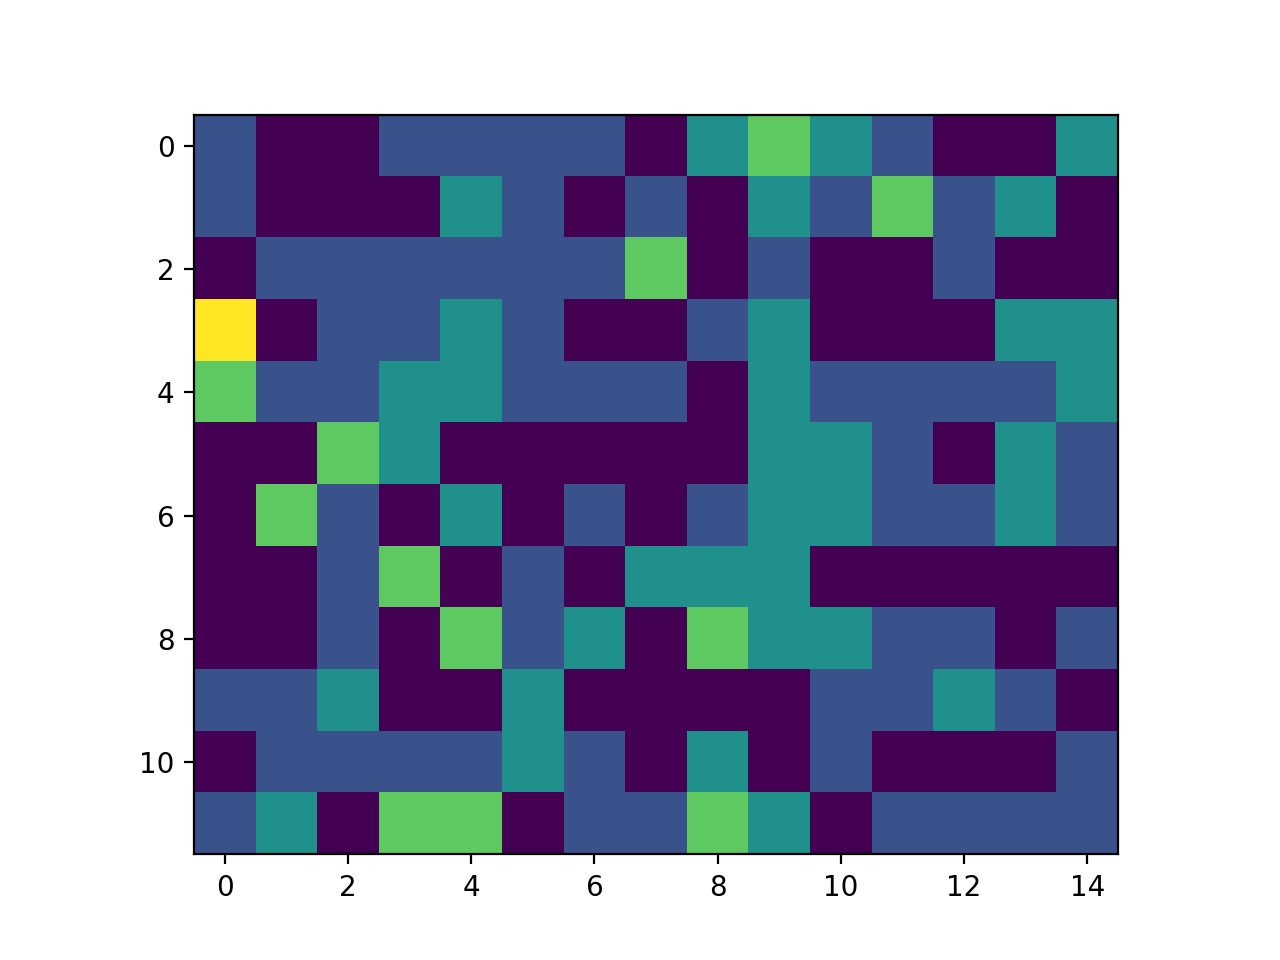

Textarea(value='', description='event:', placeholder='')

In [50]:
# clickable widget
fig = plt.figure()
plt.imshow(a)

# Create and display textarea widget
txt = widgets.Textarea(
    value='',
    placeholder='',
    description='event:',
    disabled=False
)
display(txt)

# Define a callback function that will update the textarea
def onclick(event):
    txt.value = str(event)  # Dynamically update the text box above

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)

In [73]:
# split image_id out into image_name
processed_df['image_name'] = processed_df.image_id.str.rsplit('_', n=1).str[0]
processed_df.tail(3)

,date_crop_box,date_guess,image_id,path,image_name
4176,"(2017, 517, 2606, 623)","April 2, 1951",0012_004266_003449_0001.tif_00,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003449_0001.tif
4177,"(2019, 424, 2678, 532)","January 27, 1947",0012_004266_003450_0001.tif_00,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003450_0001.tif
4178,"(543, 1118, 1071, 1203)",NaN,0012_004266_003453_0001.tif_00,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003453_0001.tif


In [74]:
# convert image_id to just the index number as a string
processed_df['image_id'] = processed_df.image_id.str.rsplit('_', n=1).str[-1]
processed_df.tail(3)

,date_crop_box,date_guess,image_id,path,image_name
4176,"(2017, 517, 2606, 623)","April 2, 1951",00,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003449_0001.tif
4177,"(2019, 424, 2678, 532)","January 27, 1947",00,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003450_0001.tif
4178,"(543, 1118, 1071, 1203)",NaN,00,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003453_0001.tif


In [75]:
# image_id as int
processed_df['image_id'] = processed_df.image_id.astype(int)
processed_df.tail(3)

,date_crop_box,date_guess,image_id,path,image_name
4176,"(2017, 517, 2606, 623)","April 2, 1951",0,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003449_0001.tif
4177,"(2019, 424, 2678, 532)","January 27, 1947",0,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003450_0001.tif
4178,"(543, 1118, 1071, 1203)",NaN,0,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_003453_0001.tif


In [76]:
## Should probably change image_id to date_id

In [77]:
# add 1 to int for image_id so I can take the highest image_id as the number of dates found
processed_df['image_id'] = processed_df.image_id + 1
processed_df.head(4)

,date_crop_box,date_guess,image_id,path,image_name
0,"(1847, 139, 2401, 239)","July 13, 1925",1,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_000001_0001.tif
1,"(2092, 436, 2750, 541)",NaN,1,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_000002_0001.tif
2,"(2629, 355, 2980, 485)","July 4,",1,data/images/0012_004266_000003_0001.tif,0012_004266_000003_0001.tif
3,"(2172, 361, 2754, 477)","July 11, 1921",1,/Volumes/jmoor167/data/tnfarmnews/0012_004266_...,0012_004266_000004_0001.tif


In [78]:
paths_df = processed_df.copy()

In [79]:
# drop path from DataFrame
processed_df = processed_df.drop(['path'], axis=1)
processed_df.head(3)

,date_crop_box,date_guess,image_id,image_name
0,"(1847, 139, 2401, 239)","July 13, 1925",1,0012_004266_000001_0001.tif
1,"(2092, 436, 2750, 541)",NaN,1,0012_004266_000002_0001.tif
2,"(2629, 355, 2980, 485)","July 4,",1,0012_004266_000003_0001.tif


In [80]:
# group rows by image_name
group_by_image_name = processed_df.groupby(['image_name', 'date_guess'])
group_by_image_name.first()

date_crop_box  \
image_name                  date_guess                                     
0012_004266_000001_0001.tif July 13, 1925         (1847, 139, 2401, 239)   
0012_004266_000003_0001.tif July 4,               (2629, 355, 2980, 485)   
0012_004266_000004_0001.tif July 11, 1921         (2172, 361, 2754, 477)   
0012_004266_000005_0001.tif July 16, 1922         (2339, 375, 2896, 483)   
                            July 18, 1922         (2339, 371, 2896, 487)   
                            July 8 were red-     (782, 1400, 1349, 1504)   
                            June 29 to July       (419, 1401, 971, 1494)   
0012_004266_000006_0001.tif July 25, 1921         (2243, 349, 2797, 455)   
0012_004266_000008_0001.tif August  8, 1921       (2162, 580, 2791, 683)   
0012_004266_000009_0001.tif August 15, 1921       (1828, 311, 2449, 424)   
0012_004266_000010_0001.tif August 22, 1921       (2298, 282, 2915, 400)   
                            August 9,-10, 11 a  (1601, 1098, 2228, 1208)   
0012_004266_000011_0001.tif August 29, 1921       (2199, 314, 2814, 443)   
0012_004266_000012_0001.tif September  5, 1921    (2232, 485, 2939, 590)   
0012_004266_000013_0001.tif September 12, 1921    (2254, 344, 2967, 448)   
0012_004266_000014_0001.tif September 19, 19.     (2308, 443, 2980, 549)   
0012_004266_000016_0001.tif October  3, 1921      (2251, 356, 2901, 451)   
0012_004266_000017_0001.tif October 10, 1921      (2061, 211, 2712, 321)   
0012_004266_000018_0001.tif October 17, 1192      (2079, 332, 2601, 431)   
                            October 17, 1921      (2185, 339, 2730, 430)   
0012_004266_000019_0001.tif October 25, 1921      (2206, 325, 2861, 424)   
0012_004266_000020_0001.tif October 31, 1921      (2050, 396, 2705, 491)   
0012_004266_000021_0001.tif November  7, 1921     (2056, 380, 2737, 477)   
0012_004266_000022_0001.tif November 14, 1921     (2128, 419, 2811, 521)   
0012_004266_000023_0001.tif November 2 1, 1921    (2148, 322, 2835, 417)   
0012_004266_000024_0001.tif Novemb er 2B, We      (2151, 401, 2837, 495)   
0012_004266_000025_0001.tif December 26, 1921     (2232, 375, 2917, 471)   
0012_004266_000026_0001.tif December 2, “4921     (2081, 336, 2766, 431)   
0012_004266_000027_0001.tif December 19, 1921     (2041, 288, 2728, 382)   
0012_004266_000028_0001.tif December 26, 1921     (1991, 283, 2679, 379)   
...                                                                  ...   
0012_004266_003426_0001.tif November 25, 1976   (2834, 1212, 3268, 1301)   
0012_004266_003428_0001.tif February 21, 1977       (245, 225, 870, 320)   
0012_004266_003429_0001.tif February 28, 1977       (277, 242, 904, 339)   
0012_004266_003430_0001.tif March  7, 1977          (257, 215, 820, 304)   
                            ‘MARCH 28           (2742, 1049, 3274, 1144)   
                            “March: 28 at       (2876, 1387, 3274, 1474)   
0012_004266_003431_0001.tif March 14, 1977          (283, 242, 844, 333)   
0012_004266_003432_0001.tif March 21, 1977          (153, 205, 770, 294)   
0012_004266_003433_0001.tif APRIL 3-5           (1621, 1067, 2228, 1163)   
0012_004266_003434_0001.tif April  4, 1977          (285, 243, 824, 339)   
                            ‘May 1              (3030, 1521, 3284, 1615)   
0012_004266_003435_0001.tif April 11, 1977          (273, 221, 810, 316)   
0012_004266_003436_0001.tif April 18, 1977          (210, 241, 748, 339)   
                            February  1, 1977   (1913, 1358, 2534, 1453)   
0012_004266_003437_0001.tif April 25, 1977          (326, 220, 863, 315)   
                            May 1 nradiurad     (1982, 1692, 2496, 1744)   
0012_004266_003438_0001.tif May  2, 1977            (101, 229, 620, 324)   
0012_004266_003439_0001.tif MAY 13-14           (1909, 1074, 2465, 1169)   
                            May  9, 1977            (265, 227, 783, 321)   
0012_004266_003440_0001.tif May 16,1977 _           (183, 217, 702, 314)   
0012_004266_003441_0001.tif May

In [82]:
# batch process text

rows_list = []

images_to_process_before_saving_csv = 20

paths_list = page_1_paths_list
# paths_list = random.sample(page_1_paths_list, len(page_1_paths_list))
number_of_paths = len(paths_list)

# progress bar
progress_label = Label('Images to process')
progress_bar = IntProgress(min=0, max=number_of_paths)
progress_widget = VBox([progress_label, progress_bar])
display(progress_widget)


for index, image_path in enumerate(paths_list, start=1):
    
    # if the image_path is already in the dataframe skip it
    if len(paths_df) > 0:
        if (paths_df['path'] == str(image_path)).any():
            # if modulo of processed images is 0 or it's the last image save data to the CSV 
            if (index % images_to_process_before_saving_csv) == 0 or index == number_of_paths:
                if len(rows_list) > 0:
                    print(f'Saving data from {index} images to {csv_path}')

                    # get dataframe from processed rows
                    crop_df = pd.DataFrame(rows_list)

                    # add dataframes together
                    processed_df = pd.concat([processed_df, crop_df])

                    # drop duplicates
                    processed_df.drop_duplicates(inplace=True)

                    # sort on image_path and reset the index
                    processed_df = processed_df.sort_values(by='image_name').reset_index(drop=True)
                    processed_df.to_csv(csv_path, index=False)

                    # reset rows_list
                    rows_list = []
            continue

    label = f'Processing {image_path.name} . . . {index+1}/{number_of_paths}'
    progress_label.value = label
    
    # process image
    issue = TnFarmNews(image_path)
    # print(issue.image_path.name)
    issue.ocr_thrice()
    image = issue.image_cropped
    # quick_imshow(image)
    height, width = issue.height_cropped, issue.width_cropped

    ocr_results_dict = {'all': issue.ocr_all_lines,
                        'left': issue.ocr_left_lines,
                        'right': issue.ocr_right_lines}

    crop_and_text_dict = OrderedDict()

    for area_ocred in ocr_results_dict:

        # print(f'OCRing image area "{area_ocred}" . . .')

        # instantiate OcrResults class to find month
        ocr_results = OcrResults(ocr_results_dict[area_ocred])

        # loop through results
        for i, result in enumerate(ocr_results.get_month()):
            # print(f'Result: {i + 1}\n{25 * "="}')
            if result is None:
                # print(issue.text)
                # print('\t\t\t\tNo acceptable results\n')
                continue
            else:
                month, word, crop_box = result
                # print(f'\t\t\t\t{month.capitalize(), word}')
                x1, y1, x2, y2 = crop_box
                
                if area_ocred == 'right':
                    cropped_width = int(width/2)
                    # add cropped back to x1 and x2
                    x1 += cropped_width
                    x2 += cropped_width
                # print(f'month crop_box: {crop_box}')
                # quick_imshow(image[y1:y2, x1:x2])

                # get larger crop_box and re-OCR
                x1 -= 25
                x1 = max(x1, 0)
                y1 -= 25
                y1 = max(y1, 0)
                x2 += 400
                x2 = min(x2, width)
                y2 += 25
                y2 = min(y2, height)

                # draw this box on larger image
                # drawing = cv2.rectangle(
                #     image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 8)
                # print('expanded month crop box on image')
                # quick_imshow(drawing)

                # crop to sub_image and ocr
                sub_image = image[y1:y2, x1:x2]
                sub_image = issue.binarize(sub_image)
                line_and_word_boxes, text = issue.ocr(sub_image)
                
                # print(f'Text:\n"{text}"\n\n')
                # print(f'{len(line_and_word_boxes)} lines in sub_image')
                
                # package sub_image's crop_box for dictionary
                date_crop_box = (x1, y1, x2, y2)
                
                # it's possible there's more than 1 line of text 
                # so make each one a possible date
                for line in line_and_word_boxes:
                    # print(line.content)
                    
                    # replace new lines with spaces
                    line = line.content.replace('\n', ' ')
                    # print(line)
                    # strip periods, single/double-quotes, and spaces at the beginning and end of the line
                    line = line.strip('.').strip(' ').strip("'").strip('"')
                    # print(line)
                    
                    # many of the lines are obviously not dates
                    # so only add lines/crop_boxes if
                    # the line contains any numbers
                    for char in line:
                        if char.isdigit():
                            crop_and_text_dict[line] = date_crop_box
                            break
                            

    # process OCR results
    
    count_for_csv = 1
    
    for date in crop_and_text_dict:
        
        parsed_date = None
        month = None
        date_guess = None
        
        if len(date) < 5:
            continue
        try:
            # print(f'Processing: "{date}"')
            parsed_date = parse(date)

        except ValueError:  # couldn't parse the date
            # split on spaces and look for each word in the months dictionary
            words = date.split(' ')
            for i, word in enumerate(words):
                
                word = str(word)  # cast word as a string in case of weirdness
                
                # only process word results over 2 chars in length
                if len(word) > 2:
                    
                    best_word = word

                    # try to match the word as lower-case with the months dictionary
                    month = search(months_dict, word.lower())  # returns None on failed search

                    if month is None:  # try autocorrecting the word and searching again
                        fixed_word = spell(word)
                        # print(f'fixed_word: {fixed_word}')
                        month = search(months_dict, fixed_word.lower())
                        best_word = fixed_word
                    
                    # try adding the previous word to every word after the first and re-searching
                    if i > 0 and month is None:
                        word_plus_word_before = words[i-1] + word
                        month = search(months_dict, word_plus_word_before.lower())
                        best_word = word_plus_word_before
                    
                    # try adding the next word to every word but the last
                    if i+1 < (len(words)) and month is None:
                        word_plus_word_after = word + words[i+1]
                        month = search(months_dict, word_plus_word_after.lower())
                        best_word = word_plus_word_after
                        

                    if month is None:  # continue to the next word
                        continue
                    else:
                        # print(f'word guess for {month} from best word: {best_word}')
                        # set day_year to index + 1 to the end of words list
                        day_year = ' '.join(words[i+1:])  # join the words list and add the space back
                        
                        corrected_date = f'{month} {day_year}'
                        # print(f'after: {corrected_date}')
                        try:
                            parsed_date = parse(corrected_date)
                            # print(f'parsed date: {parsed_date}')
                        except ValueError:
                            try:
                                parsed_date = parse(corrected_date, fuzzy=True)
                                # print(f'fuzzy parsed date: {parsed_date}')
                            except ValueError:
                                # parsed_date = "Date couldn't be parsed"
                                continue
        
        if parsed_date is None:
            # if we found a month go ahead and post the text value
            # of the found date as it may be correct
            # print(f'month in parsed_data is None: {month}')
            if month:
                date_guess = str(date)
            else:
                date_guess = None

        # if date after 2000 just pass the text
        elif int(parsed_date.strftime("%Y")) > 1999:
            date_guess = str(date)
        #     if month:
        #         date_guess = str(date)
        #     else:
        #         date_guess = None
        
        else:
            # print(f'Type of parsed_date: {type(parsed_date)}')
            date_guess = parsed_date.strftime("%B %e, %Y")
            month = parsed_date.strftime("%B")
            day = parsed_date.strftime("%d")  # %d keeps leading zero on days
            day_no_leading_zero = parsed_date.strftime("%e")  # %e drops it
            year = parsed_date.strftime("%Y")
            # if first digit of year is 0, change it to 1
            if int(year[0]) == 0:
                # print(f'year <1000: {year}')
                year = '1' + year[1:]
                # print(f'year fixed: {year}')
                # then rebuild date_guess
                date_guess = f'{month} {day_no_leading_zero}, {year}'
            elif int(year[1]) != 9:
                year = '19' + year[2:]
                # then rebuild date_guess
                date_guess = f'{month} {day_no_leading_zero}, {year}'

        crop_box = crop_and_text_dict[date]
        
        x1, y1, x2, y2 = crop_box
        
#         # draw this box on the ocr_all image
#         drawing = cv2.rectangle(image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 8)
#         # draw a black rectangle above this to add text to
#         drawing = cv2.rectangle(drawing, (x1, y1-100), (x2, y1), (0, 0, 0), -1)  # negative thickness to fill rectangle
        
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         print(f'date_guess before fail: {date_guess}')
#         if date_guess is not None:
#             date_writing = date_guess
#         else:
#             date_writing = 'Date Guess Fail'
#         cv2.putText(drawing, date_writing, (x1+25, (y1-25)), font, 2, (255,255,255), 3, cv2.LINE_AA)
              
#         quick_imshow(drawing)
        
        # get input row in dictionary format
        # key = column_name
        results_dictionary = {'image_id': count_for_csv,
                              'image_name': image_path.name,
                              'date_guess': date_guess,
                              'date_crop_box': crop_box,
                              # 'year_guess': issue.MOST_MATCHES,
                              }

        for key in results_dictionary:
            if results_dictionary[key]:
                continue
            else:
                results_dictionary.update({key: None})

        rows_list.append(results_dictionary)
        # increment counter for imageID 
        count_for_csv += 1
        
    progress_bar.value = index
    
    # if modulo of processed images is 0 or it's the last image save data to the CSV 
    if (index % images_to_process_before_saving_csv) == 0 or index == number_of_paths:
        
        print(f'Saving data from {index} images to {csv_path}')
        
        # get dataframe from processed rows
        crop_df = pd.DataFrame(rows_list)
        
        # add dataframes together
        processed_df = pd.concat([processed_df, crop_df])

        # drop duplicates
        processed_df.drop_duplicates(inplace=True)

        # sort on image_path and reset the index
        processed_df = processed_df.sort_values(by='image_name').reset_index(drop=True)
        processed_df.to_csv(csv_path, index=False)
        
        # reset rows_list
        rows_list = []

Saving data from 20 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 40 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 60 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 80 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 100 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 120 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 140 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 160 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 180 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 200 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 220 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 240 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 260 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Sav

/Users/jeremy/miniconda3/envs/img_qc/lib/python3.7/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname T identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


Saving data from 1860 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 1880 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 1900 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 1920 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 1940 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 1960 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 1980 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 2000 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 2020 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 2040 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 2060 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 2080 images to /Volumes/jmoor167/data/agrtfn/agrtfn_date.csv
Saving data from 2100 images to /Volumes/jmoor167/data/agrtfn/ag

In [70]:
# batch process text

rows_list = []

images_to_process_before_saving_csv = 20

# paths_list = [Path('data/images/0012_004266_000331_0001.tif')]
paths_list = random.sample(page_1_paths_list, len(page_1_paths_list))
number_of_paths = len(paths_list)

# progress bar
progress_label = Label('Images to process')
progress_bar = IntProgress(min=0, max=number_of_paths)
progress_widget = VBox([progress_label, progress_bar])
display(progress_widget)


for index, image_path in enumerate(paths_list, start=1):
    
    # if the image_path is already in the dataframe skip it
    if len(processed_df) > 0:
        if (processed_df['path'] == str(image_path)).any():
            # if modulo of processed images is 0 or it's the last image save data to the CSV 
            if (index % images_to_process_before_saving_csv) == 0 or index == number_of_paths:
                if len(rows_list) > 0:
                    print(f'Saving data from {index} images to {csv_path}')

                    # get dataframe from processed rows
                    crop_df = pd.DataFrame(rows_list)

                    # add dataframes together
                    processed_df = pd.concat([processed_df, crop_df])

                    # drop duplicates
                    processed_df.drop_duplicates(inplace=True)

                    # sort on image_path and reset the index
                    processed_df = processed_df.sort_values(by='image_id').reset_index(drop=True)
                    processed_df.to_csv(csv_path, index=False)

                    # reset rows_list
                    rows_list = []
            continue

    label = f'Processing {image_path.name} . . . {index+1}/{number_of_paths}'
    progress_label.value = label
    
    # process image
    issue = TnFarmNews(image_path)
    # print(issue.image_path.name)
    issue.ocr_thrice()
    image = issue.image_cropped
    # quick_imshow(image)
    height, width = issue.height_cropped, issue.width_cropped

    ocr_results_dict = {'all': issue.ocr_all_lines,
                        'left': issue.ocr_left_lines,
                        'right': issue.ocr_right_lines}

    crop_and_text_dict = OrderedDict()

    for area_ocred in ocr_results_dict:

        # print(f'OCRing image area "{area_ocred}" . . .')

        # instantiate OcrResults class to find month
        ocr_results = OcrResults(ocr_results_dict[area_ocred])

        # loop through results
        for i, result in enumerate(ocr_results.get_month()):
            # print(f'Result: {i + 1}\n{25 * "="}')
            if result is None:
                # print(issue.text)
                # print('\t\t\t\tNo acceptable results\n')
                continue
            else:
                month, word, crop_box = result
                # print(f'\t\t\t\t{month.capitalize(), word}')
                x1, y1, x2, y2 = crop_box
                
                if area_ocred == 'right':
                    cropped_width = int(width/2)
                    # add cropped back to x1 and x2
                    x1 += cropped_width
                    x2 += cropped_width
                # print(f'month crop_box: {crop_box}')
                # quick_imshow(image[y1:y2, x1:x2])

                # get larger crop_box and re-OCR
                x1 -= 25
                x1 = max(x1, 0)
                y1 -= 25
                y1 = max(y1, 0)
                x2 += 400
                x2 = min(x2, width)
                y2 += 25
                y2 = min(y2, height)

                # draw this box on larger image
                # drawing = cv2.rectangle(
                #     image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 8)
                # print('expanded month crop box on image')
                # quick_imshow(drawing)

                # crop to sub_image and ocr
                sub_image = image[y1:y2, x1:x2]
                sub_image = issue.binarize(sub_image)
                line_and_word_boxes, text = issue.ocr(sub_image)
                
                # print(f'Text:\n"{text}"\n\n')
                # print(f'{len(line_and_word_boxes)} lines in sub_image')
                
                # package sub_image's crop_box for dictionary
                date_crop_box = (x1, y1, x2, y2)
                
                # it's possible there's more than 1 line of text 
                # so make each one a possible date
                for line in line_and_word_boxes:
                    # print(line.content)
                    
                    # replace new lines with spaces
                    line = line.content.replace('\n', ' ')
                    # print(line)
                    # strip periods, single/double-quotes, and spaces at the beginning and end of the line
                    line = line.strip('.').strip(' ').strip("'").strip('"')
                    # print(line)
                    
                    # many of the lines are obviously not dates
                    # so only add lines/crop_boxes if
                    # the line contains any numbers
                    for char in line:
                        if char.isdigit():
                            crop_and_text_dict[line] = date_crop_box
                            break
                            

    # process OCR results
    
    count_for_csv = 1
    
    for date in crop_and_text_dict:
        
        parsed_date = None
        month = None
        date_guess = None
        
        if len(date) < 5:
            continue
        try:
            # print(f'Processing: "{date}"')
            parsed_date = parse(date)

        except ValueError:  # couldn't parse the date
            # split on spaces and look for each word in the months dictionary
            words = date.split(' ')
            for i, word in enumerate(words):
                
                word = str(word)  # cast word as a string in case of weirdness
                
                # only process word results over 2 chars in length
                if len(word) > 2:
                    
                    best_word = word

                    # try to match the word as lower-case with the months dictionary
                    month = search(months_dict, word.lower())  # returns None on failed search

                    if month is None:  # try autocorrecting the word and searching again
                        fixed_word = spell(word)
                        # print(f'fixed_word: {fixed_word}')
                        month = search(months_dict, fixed_word.lower())
                        best_word = fixed_word
                    
                    # try adding the previous word to every word after the first and re-searching
                    if i > 0 and month is None:
                        word_plus_word_before = words[i-1] + word
                        month = search(months_dict, word_plus_word_before.lower())
                        best_word = word_plus_word_before
                    
                    # try adding the next word to every word but the last
                    if i+1 < (len(words)) and month is None:
                        word_plus_word_after = word + words[i+1]
                        month = search(months_dict, word_plus_word_after.lower())
                        best_word = word_plus_word_after
                        

                    if month is None:  # continue to the next word
                        continue
                    else:
                        # print(f'word guess for {month} from best word: {best_word}')
                        # set day_year to index + 1 to the end of words list
                        day_year = ' '.join(words[i+1:])  # join the words list and add the space back
                        
                        corrected_date = f'{month} {day_year}'
                        # print(f'after: {corrected_date}')
                        try:
                            parsed_date = parse(corrected_date)
                            # print(f'parsed date: {parsed_date}')
                        except ValueError:
                            try:
                                parsed_date = parse(corrected_date, fuzzy=True)
                                # print(f'fuzzy parsed date: {parsed_date}')
                            except ValueError:
                                # parsed_date = "Date couldn't be parsed"
                                continue
        
        if parsed_date is None:
            # if we found a month go ahead and post the text value
            # of the found date as it may be correct
            # print(f'month in parsed_data is None: {month}')
            if month:
                date_guess = str(date)
            else:
                date_guess = None

        # if date after 2000 just pass the text
        elif int(parsed_date.strftime("%Y")) > 1999:
            date_guess = str(date)
        #     if month:
        #         date_guess = str(date)
        #     else:
        #         date_guess = None
        
        else:
            # print(f'Type of parsed_date: {type(parsed_date)}')
            date_guess = parsed_date.strftime("%B %e, %Y")
            month = parsed_date.strftime("%B")
            day = parsed_date.strftime("%d")  # %d keeps leading zero on days
            day_no_leading_zero = parsed_date.strftime("%e")  # %e drops it
            year = parsed_date.strftime("%Y")
            # if first digit of year is 0, change it to 1
            if int(year[0]) == 0:
                # print(f'year <1000: {year}')
                year = '1' + year[1:]
                # print(f'year fixed: {year}')
                # then rebuild date_guess
                date_guess = f'{month} {day_no_leading_zero}, {year}'
            elif int(year[1]) != 9:
                year = '19' + year[2:]
                # then rebuild date_guess
                date_guess = f'{month} {day_no_leading_zero}, {year}'

        crop_box = crop_and_text_dict[date]
        
        x1, y1, x2, y2 = crop_box
        
#         # draw this box on the ocr_all image
#         drawing = cv2.rectangle(image.copy(), (x1, y1), (x2, y2), (0, 0, 255), 8)
#         # draw a black rectangle above this to add text to
#         drawing = cv2.rectangle(drawing, (x1, y1-100), (x2, y1), (0, 0, 0), -1)  # negative thickness to fill rectangle
        
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         print(f'date_guess before fail: {date_guess}')
#         if date_guess is not None:
#             date_writing = date_guess
#         else:
#             date_writing = 'Date Guess Fail'
#         cv2.putText(drawing, date_writing, (x1+25, (y1-25)), font, 2, (255,255,255), 3, cv2.LINE_AA)
              
#         quick_imshow(drawing)
        
        # get input row in dictionary format
        # key = column_name
        results_dictionary = {'image_id': count_for_csv,
                              'image_name': image_path.name,
                              'date_guess': date_guess,
                              'date_crop_box': crop_box,
                              # 'year_guess': issue.MOST_MATCHES,
                              }

        for key in results_dictionary:
            if results_dictionary[key]:
                continue
            else:
                results_dictionary.update({key: None})

        rows_list.append(results_dictionary)
        # increment counter for imageID 
        count_for_csv += 1
        
    progress_bar.value = index
    
    # if modulo of processed images is 0 or it's the last image save data to the CSV 
    if (index % images_to_process_before_saving_csv) == 0 or index == number_of_paths:
        
        print(f'Saving data from {index} images to {csv_path}')
        
        # get dataframe from processed rows
        crop_df = pd.DataFrame(rows_list)
        
        # add dataframes together
        processed_df = pd.concat([processed_df, crop_df])

        # drop duplicates
        processed_df.drop_duplicates(inplace=True)

        # sort on image_path and reset the index
        processed_df = processed_df.sort_values(by='image_id').reset_index(drop=True)
        processed_df.to_csv(csv_path, index=False)
        
        # reset rows_list
        rows_list = []

KeyError: 'path'

In [ ]:
# get dataframe from processed rows
crop_df = pd.DataFrame(rows_list)

# add dataframes together
processed_df = pd.concat([processed_df, crop_df], sort=False)

# drop duplicates
processed_df.drop_duplicates(subset=['image_id'], inplace=True)

# sort on image_path and reset the index
processed_df = processed_df.sort_values(by='image_id').reset_index(drop=True)
processed_df.to_csv(csv_path, index=False)

In [ ]:
len(processed_df)

In [ ]:
processed_df

In [ ]:
test_date = date.strip('"')#.strip('.')# date.replace(',', '').replace('.', '').replace('"', '')
test_date

In [ ]:
parse(test_date)

In [ ]:
print(date.replace('\n', ' '))

In [ ]:
date_csv_path = data_dir_path.joinpath('TnFarmNews_date.csv')
if date_csv_path.is_file():
    processed_df = pd.read_csv(date_csv_path)
else:
    processed_df = pd.DataFrame()
processed_df

In [ ]:
# anything in the new fail list not in the old fail list?
test = fail_df.merge(old_fail_df, how='outer', indicator=True).query(
    '_merge == "left_only"').drop('_merge', 1)
test.reset_index(drop=True)

In [ ]:
image_path = crop_df['image_path'][0]
image = cv2.imread(str(image_path))
x1, y1, x2, y2 = crop_df['title_crop'][0]
image_cropped = image[y1:y2, x1:x2]
plt.imshow(image), plt.show()
plt.imshow(image_cropped), plt.show()

In [ ]:
@interact
def show_images(file=page_1_paths_list):
    # load image
    issue = TnFarmNews(file)
    issue.ocr()
    # draw_month_box(issue.line_and_word_boxes, issue.image_cropped)
    # image = Image.open(file)
    # temp_image_path = Path('_temp_image.jpg')
    # image.save(temp_image_path)
    # display(ipyImage(temp_image_path))
    issue.guess_title(title_crops_dict, debug=True)
    print(issue.best_title)

In [ ]:
# this is my attempt to try and make a crop-value widget!

page_1_paths_dictionary = {path.name: path for path in page_1_paths_list}
initial_path = page_1_paths_list[0]
initial_images_key = initial_path.name
initial_image = cv2.imread(image)
initial_x2 =

# Create widgets
images = widgets.Dropdown(
    options=page_1_paths_dictionary, value=initial_path_key)
crop_x1 = widgets.IntRangeSlider(value=(100, , min=0, max=initial_image.shape[1])
crop_y1=widgets.IntSlider(value=0, min=0, max=initial_image.shape[0])
crop_x2=widgets.IntSlider()

# Updates the image options based on directory value
def update_crop(*args):
    crop_x1.max=os.listdir(directory.value)

# Tie the image options to directory value
directory.observe(update_crop, 'value')

# Show the images
def show_images(fdir, file):
    display(Image(f'{fdir}/{file}'))

_=interact(show_images, fdir=directory, file=images)
def crop_image(file=page_1_paths_list, x1=(0, Image.open(file).size[0])):
    # load image
    issue=TnFarmNews(file)
    issue.ocr()
    draw_month_box(issue.line_and_word_boxes, issue.image_cropped)
    # image = Image.open(file)
    # temp_image_path = Path('_temp_image.jpg')
    # image.save(temp_image_path)
    # display(ipyImage(temp_image_path))
    issue.guess_title(debug=True)
    print(issue.best_title)